In [1]:
# !pip install rdkit kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.2/28.2 MB 21.3 MB/s eta 0:00:0000:0100:01
  Using cached kaggle-1.6.12-py3-none-any.whl
  Using cached certifi-2024.2.2-py3-none-any.whl (163 kB)
  Using cached python_slugify-8.0.4-py2.py3-none-any.whl (10 kB)
  Using cached text_unidecode-1.3-py2.py3-none-any.whl (78 kB)
  Attempting uninstall: certifi
    Found existing installation: certifi 2022.9.24
    Uninstalling certifi-2022.9.24:
      Successfully uninstalled certifi-2022.9.24

[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
# !pip install pyvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 3.6 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [1]:
import time
import sys
import pickle
import numpy      as np
import pandas     as pd
import matplotlib.pyplot as plt
import seaborn    as sns
import networkx   as nx  # For creating and manipulating graph structures

from   zipfile    import ZipFile
from collections  import Counter
import random
import re
import psutil
import copy
import os

from rdkit import Chem
from rdkit.Chem import FunctionalGroups

from tqdm       import tqdm

In [7]:
with ZipFile('zinc250k.zip') as zp:
    zinc_data = pd.read_csv(zp.open('250k_rndm_zinc_drugs_clean_3.csv'))

adjusted_smiles  = []
for index, smile in enumerate(zinc_data['smiles']):
  smile          = smile.replace('\n', '')
  adjusted_smiles.append(smile)

zinc_data['smiles'] = adjusted_smiles

**Data Details**
1. ssr contains list of lists with indexes that correspond to rings
2. Atoms contains the symbol of the atom corresponding to index
3. Bonds contains tuples of bonded indexes

**More information for JT Algo 24Feb2024**

atom Information:
--
1. Atomic Number: The atomic number uniquely identifies the element of each atom.
2. Formal Charge: The formal charge can affect the molecule's reactivity and properties.
3. Hybridization: The hybridization state of an atom can influence molecular geometry.
4. Explicit and Implicit Hydrogens: Knowing the number of attached hydrogens is crucial for understanding the molecule's structure.
5. Isotope Information: For molecules with isotopes, this information is necessary.
    
Bond Information:
--   
1. Bond Order: You're already capturing single, double, and triple bonds but ensure to include any aromatic bonds explicitly as their electronic structure can influence reactivity.
2. Stereochemistry: For bonds, capturing cis/trans (E/Z) configurations is important for double bonds.

Substructure and Functional Groups:
--
1. Functional Groups: You hinted at identifying alcohols; systematically extend this to other functional groups like carbonyls, amines, etc., as they play significant roles in the molecule's properties and reactivity.
2. Ring Structures: Information about ring size, aromaticity, and saturation can be crucial, especially for heterocyclic compounds.

Stereochemistry:
--
1. Chiral Centers: You're capturing chiral centers, which is excellent. Ensure to include their absolute configuration (R/S) as it can drastically change a molecule's biological activity.
2. Axial and Planar Chirality: For molecules with more complex chiral structures, such as those with axial chirality (e.g., biaryls) or planar chirality.

Molecular Connectivity:
--
1. Graph Representation: Since you're working with a JT-VAE, representing the molecule as a graph (nodes for atoms and edges for bonds) is fundamental. Including connectivity information (which atoms are bonded to which) in a structured format like SMILES or InChI can also be useful for re-constructing the molecule.
2. Physical and Chemical Properties (optional):
While not directly related to the structure, including properties like molecular weight, logP (a measure of hydrophobicity), or even polar surface area could enrich your model's ability to predict not just the structure but also the likeliness of a molecule's existence and its physical behavior.


**Paper Additional Information for Vocabulary 03Mar2024**
1. Each vertex v has a feature vector xv indicating the atom type, valence, and other properties. Similarly, each edge (u,v) ∈ E has a feature vector xuv indicating its bond type, and two hidden vectors νuv and νvu denoting the message from u to v and vice versa.

In [8]:
def metadata_smiles(bonds, mol, smile, atoms_dict):
    
    ''' 
    Get important metadata associated with a molecule to uniquely identify a molecule
    --------------------------------------------------------------------------------
    --------------------------------------------------------------------------------
    
    Parameters:
        bonds:
        mol:
        smile:
        atoms_dict:
        
    Returns:
        molecule_info:
        
    '''
    # Identify aromatic rings and bond types

    stereo_config_map = {
        Chem.rdchem.BondStereo.STEREOZ: 'cis',
        Chem.rdchem.BondStereo.STEREOE: 'trans',
        Chem.rdchem.BondStereo.STEREONONE: 'none',  # No stereochemistry specified
    }

    atoms             = mol.GetAtoms()
    total_hydrogens   = [atom.GetTotalNumHs() for atom in atoms]
    bonds             = mol.GetBonds()
    aromatic_atoms    = [atom.GetIdx() for atom in atoms if atom.GetIsAromatic()]
    double_bonds      = [bond.GetIdx() for bond in bonds if bond.GetBondType() == Chem.rdchem.BondType.DOUBLE]
    double_bonds_info = [stereo_config_map[bond.GetStereo()] for bond in bonds 
                       if bond.GetBondType() == Chem.rdchem.BondType.DOUBLE]


    triple_bonds      = [bond.GetIdx() for bond in bonds if bond.GetBondType() == Chem.rdchem.BondType.TRIPLE]
    #   fgs               = FunctionalGroups.FindFunctionalGroups(mol)
    double_isomerism  = []
    double_list       = []
    hydrogen_counts   = []
    # Iterate over the neighbors of the atom

    for index, bond in enumerate(double_bonds):
        bond_object       = bonds[bond]
        bond_isomerism    = double_bonds_info[index]              
        double_bond_atoms = tuple(sorted((bond_object.GetBeginAtomIdx(), bond_object.GetEndAtomIdx())))
        double_list.append(double_bond_atoms)
        double_isomerism.append(bond_isomerism)

    # Dictionary to map RDKit's stereo configuration enumeration to human-readable strings

    triple_list         = []
    for bond in triple_bonds:
        bond_object       = bonds[bond]
        triple_bond_atoms = tuple(sorted((bond_object.GetBeginAtomIdx(), bond_object.GetEndAtomIdx())))
        triple_list.append(triple_bond_atoms)

    # Remove triple and double bonds from list
    # bonds             = [bond for bond in bonds if bond.GetBondType() != Chem.rdchem.BondType.DOUBLE
    #                     and bond.GetBondType() != Chem.rdchem.BondType.TRIPLE]

    tertiary_atoms      = [atom.GetIdx() for atom in atoms if atom.GetDegree() == 3
                       and atom.GetChiralTag() == Chem.rdchem.ChiralType.CHI_UNSPECIFIED
                       and not atom.IsInRing()]
    quaternary_atoms    = [atom.GetIdx() for atom in atoms if atom.GetDegree() == 4
                       and atom.GetChiralTag() == Chem.rdchem.ChiralType.CHI_UNSPECIFIED
                       and not atom.IsInRing()]
    bonded_atoms        = [(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()) for bond in bonds]
    # Identify functional groups (as an example, using alcohols)
    # alcohol_groups = mol.GetSubstructMatches(Chem.MolFromSmarts('CO'))
    valency             = [atom.GetExplicitValence() for atom in atoms]

    # Identify chiral centers
    chiral_centers      = Chem.FindMolChiralCenters(mol, includeUnassigned=True)

    # Assemble the information
    molecule_info     = {
      "atoms":  atoms_dict,
      'bonds':  bonded_atoms,
      "Aromatic_Atoms": aromatic_atoms,
      "Double_Bonds":   double_list,
      "Triple_Bonds":   triple_list,
      "Chiral_Centers": chiral_centers,
      'Tertiary': tertiary_atoms,
      'Quaternary': quaternary_atoms,
      'Bond_Isomerism': double_isomerism,
      'Bonded Hydrogens': total_hydrogens,
      'valence': valency
    }


    return molecule_info


**I have no idea what to do**
1. Take the paper statement to heart: Each vertex v has a feature vector xv indicating the atom type, valence, and other properties. Similarly, each edge (u,v) ∈ E has a feature vector xuv indicating its bond type, and two hidden vectors νuv and νvu denoting the message from u to v and vice versa. 

In [9]:
def atom_equal(a1, a2):
    return a1.GetSymbol() == a2.GetSymbol() and a1.GetFormalCharge() == a2.GetFormalCharge()

In [12]:
# def debug(mol):
    
#     atom_obj      = [atom for atom in mol.GetAtoms()]
#     valency       = [atom.GetExplicitValence() for atom in atom_obj]
    
#     return valency


# for index in range(10):
#     mol = Chem.MolFromSmiles(zinc_data['smiles'][index])
    
#     print(debug(mol))

In [13]:
def get_rings(ssr, non_ring_bonds, atoms, molecule, v2, v1, v2_ring, i):
    ''' 
    Pulls the metadata associated with ring structures
    
    Parameters:
        ssr: RDKIT smallest set of rings
        non_ring_bonds:
        atoms: all atoms in the smiles object
        molecule: 
        v2: 
        v1: 
        v2_ring:
        i: Current index of the iteration
        
        
    Returns:
        v2_ring: The set of atoms belonging to a ring structure
        v1: The set of atoms not belonging to a ring structure
        
    '''
    
    
    # Iterate Through Rings
    for ring in ssr:
      temp_atoms = copy.copy(atoms)

      for index in range(len(ring)):
        begin_atom_idx = ring[index]
        end_atom_idx   = ring[(index + 1) % len(ring)]  # To loop back to the start
        bond           = molecule.GetBondBetweenAtoms(begin_atom_idx, end_atom_idx)

        if bond is not None:
            bond_idx_tuple = tuple(sorted((begin_atom_idx, end_atom_idx)))
            v2.add(bond_idx_tuple)

      # v2
      non_ring_bonds     = set(sorted(non_ring_bonds)) - set(sorted(v2))

      subset_dict        = [atoms, v2, non_ring_bonds]
      v1[i]              = non_ring_bonds

      # Stores all V2 rings after some post-processing
      v2_ring[i]         = ssr
    
 
    return v2_ring, v1, v2

In [14]:
def bridged_rings(v2_copy, v2_ring, i):
    
    ''' 
    This function merges bridges rings which are defined by having more than
    two atoms shared (tertiary atom in ring indicates ring structure)
    
    Parameters:
        v2_copy: A copy of the v2_ring object used so that v2_ring can be updated dynamically
        v2_ring: a dynamic v2_ring object that is updated with merged rings.
        i: index of the current iteration
        
    Returns:
        v2_ring: The updated v2_ring dictionary with merged rings
        
    '''

    # Could be optimized to not evaluate r1 and r2, as well as r2 and r1 (order doesn't matter)
    tested_combinations = []
    for r1 in v2_copy:
        for r2 in v2_copy:
            
            # Make sure this actually works (comment out if it doesn't 21 Apr 2024)
            combination = (r1, r2)
            if combination in tested_combinations:
                break
            else:
                tested_combinations.append(combination)
                
            # Don't evaluate identical rings and fit algorithm criteria
            if r1 != r2 and len(set(r1).intersection(r2)) > 2:
                
                # Merge r1 and r2
                new_ring       = list(set(r1 + r2))

                # LEFT OFF HERE V2_ring[14004] does not exist look into why 11Feb2024
                v2_ring[i]     =  [ring for ring in v2_ring[i] if ring not in [r1, r2]]

                # Assured our rings are not duplicated
                if new_ring not in v2_ring[i]:
                  v2_ring[i].append(new_ring)
                
                
    return v2_ring

In [15]:
def construct_junction_tree(V, v1, i):
    ''' 
    Create the junction tree from the nodes that were created
    --------------------------------------------------------
    --------------------------------------------------------
    
    Parameters:
        V: All nodes (V2, V1, V0)
        v1:
        i: Current iteration
        
    Returns:
        junction_tree: The graph structure for molecular connectivity based on V
        
    '''
    
     # Add nodes for each cluster (ring or bond)
    junction_tree = nx.Graph()
    for cluster in V:
        junction_tree.add_node(cluster)

     # Add edges between clusters that share junction atoms
    # Finds the shared atoms for Nodes
    for cluster1 in junction_tree.nodes():
        for cluster2 in junction_tree.nodes():
            if cluster1 != cluster2:

                # Different combinations of Tertiary, single atoms, and ring bonds
                shared_atoms = None
                if isinstance(cluster1, int) and isinstance(cluster2, int):
                  shared_atoms = set([cluster1]).intersection(set([cluster2]))
                elif isinstance(cluster2, int):
                    if cluster2 in cluster1:  # If the single atom is in the cluster
                        shared_atoms = set([cluster2])
                elif isinstance(cluster1, int):
                    if cluster1 in cluster2:  # If the single atom is in the cluster
                        shared_atoms = set([cluster1])
                else:
                  shared_atoms = set(cluster1).intersection(set(cluster2))

                 # Conditions to check for consecutive v1 bonds... (1,2) should be connected to (2, 4)
                if shared_atoms is not None and len(shared_atoms) > 0:
                  contains_index = any(list(shared_atoms) in tup for tup in list(v1[i]))
                  v1_bonds       = True in [list(shared_atoms)[0] in tup for tup in list(v1[i])]

                if shared_atoms:
                    junction_tree.add_edge(cluster1, cluster2, weight=1)
    
    
    return junction_tree

In [16]:
def smiles_to_matrix(zinc_data):
  ''' 
  Turns the smiles into a matrix form
  -----------------------------------------
  -----------------------------------------
  
  Parameters:
  
  Returns:
  
  ''' 
  v1                   = {}
  v2_ring              = {}
  adjacency_matricies  = []
  atom_dict            = {}
  molecule_df          = {}
  max_spanning_trees   = []
    
  # May not have to store V2_ring and V1 in dictionary since 
  # They are not used outside of their iteration 21 Apr 2024
  for i, smile in tqdm(enumerate(zinc_data['smiles']), total = len(zinc_data)):
    molecule         = Chem.MolFromSmiles(smile)
    atoms            = [atom.GetSymbol() for atom in molecule.GetAtoms()]

    # Store original atom indexes in dictionary for later to create molecule tokens
    atom_dict        = {index: atom for index, atom in enumerate(atoms)}
    bonds            = [tuple(sorted((bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()))) for bond in molecule.GetBonds()]
    ssr              = [list(x) for x in Chem.GetSymmSSSR(molecule)]  # GetSymmSSSR finds smallest set of smallest rings
    
    # Initialize 
    v2               = set()
    non_ring_bonds   = set(sorted(bonds))
    
    # Pull molecule metadata
    molecule_df[i]    = metadata_smiles(bonds, molecule, smile, atom_dict)
    
    # Define V2_ring, V1 in Junction Tree Algorithm
    v2_ring, v1, v2  = get_rings(ssr, 
                               non_ring_bonds,
                               atoms, 
                               molecule,
                               v2, 
                               v1,
                               v2_ring,
                               i)

    # Step 2: Merge Bridged Rings
    # Example of Bridged Ring: Bicyclo[2.2.2]octane
    if len(ssr) > 0:
      v2_copy     = copy.deepcopy(v2_ring[i])
    # If no rings, all bonds are the bonds calculated initially
    else:
      v1[i]       = bonds
      v2_ring[i]  = None
      v2_copy     = []

    # Create the v2_ring dict with bridged rings merged
    v2_ring        = bridged_rings(v2_copy, v2_ring, i)

    # Step 3: Find Intersection Atoms (V0)
    # V0 ← atoms being the intersection of three or more clusters in V1 ∪ V2
    # Property that finds tertiary carbons/ any other tertiary molecules (Mostly Carbons)
    all_clusters   = list(v1[i]) + list(v2)
    atoms          = [atom for cluster in all_clusters for atom in cluster]
    atom_counts    = Counter(atoms)
    atom_obj       = molecule.GetAtoms()
    
    # Look for tertiary or quaternary atoms given they are not in rings (bridged rings)
    v0             = {atom for atom, count in atom_counts.items() if count >= 3
                      and not atom_obj[atom].IsInRing()}

    # Join the set of all nodes (V)
    V              = set().union(v1[i])
    if len(ssr) > 0:
      v2_ring[i]   = set([tuple(sub_list) for sub_list in v2_ring[i]])
      V            = V.union([ring for ring in v2_ring[i]])
    V              = V.union(v0)  # Add all atoms from v0

    # Construct the Junction Tree
    junction_tree   = construct_junction_tree(V, v1, i)

    if i > 1000:
        break
        
    # Step 5: Find Maximum Spanning Tree
    mst                    = nx.maximum_spanning_tree(junction_tree)

    # Get the adjacency matrix representing connections
    adj_matrix             = nx.adjacency_matrix(mst)
    adj_matrix             = adj_matrix.todense()
    
    adjacency_matricies.append(adj_matrix)
    max_spanning_trees.append(mst)

  return adjacency_matricies, molecule_df, max_spanning_trees

adjacency_matricies, molecule_df, junction_tree = smiles_to_matrix(zinc_data)


# adjacency_matricies = pickle.load(open('adjacency_matricies.pckl', 'rb'))
# molecule_df         = pickle.load(open('molecule_df.pckl', 'rb'))
# junction_tree       = pickle.load(open('junction_tree.pckl', 'rb'))

print('files_loaded')

  0%|          | 1001/249455 [00:04<16:38, 248.89it/s]

files_loaded


In [12]:
def write_to_pckl(matricies):
    for key, arg in matricies.items():
        pickle.dump(arg, open(f'{key}', 'wb'))
        
    return


# matricies = {'adjacency_matricies11Mar.pckl': adjacency_matricies,
#             'molecule_df11Mar.pckl': molecule_df,
#             'junction_tree11Mar.pckl': junction_tree}

adjacency_matricies = pickle.load(open('adjacency_matricies.pckl', 'rb'))
molecule_df         = pickle.load(open('molecule_df.pckl', 'rb'))
junction_tree       = pickle.load(open('junction_tree.pckl', 'rb'))


molecule_df[10]

In [13]:
def pad_matricies(adjacency_matricies):
  ''' 
  This function takes the adjacency matricies and pads them to 
  a n x n matrix so that all matricies are the same length
  
  Parameters:
      adjacency_matricies:
      
  Returns:
      padded_matricies:
      
  '''

  shapes = []
  for adj_matrix in adjacency_matricies:
    shape = adj_matrix.shape
    shapes.append(shape)

  padding_value = max(shapes)[0] # pull dimension


  padded_matricies = []
  for adj_matrix in tqdm(adjacency_matricies, total = len(adjacency_matricies)):
    # Determine current shape
    current_shape = adj_matrix.shape

    # Calculate padding needed
    padding       = ((0, max(0, padding_value - current_shape[0])),  # Padding for rows
                     (0, max(0, padding_value - current_shape[1])))  # Padding for columns

    # Apply padding
    padded_matrix = np.pad(adj_matrix, padding, mode='constant', constant_values=0)
    padded_matricies.append(padded_matrix)
    
    
  padded_matricies = np.array(padded_matricies)
  return padded_matricies


padded_matricies = pad_matricies(adjacency_matricies)


100%|██████████| 249455/249455 [00:25<00:00, 9889.28it/s] 


**Uniquely Identifying Substructures**
1. Rings are their own "words"
2. Aromaticity, atoms in ring, # of atoms are needed to identify
3. Chirality is likely important
4. Current Nodes in MST Represent candidates for vocabulary
5. Double and triple bonds can be found by the index in bonds sub dictionary and then calliung atoms dictionary

In [14]:
def construct_vocabulary(adjacency_matricies, molecule_df, junction_tree):
  '''
  Construct Vocabulary for the adjacency matrix, molecule_df, and junction tree
  ------------------------------------------------------------------
  ------------------------------------------------------------------
  Parameters:
    adjacency_matricies: N x N Matrix representing nodes in graph representation
    molecule_df: metadata of molecules including
    junction_tree:

  Returns:
    vocabulary:

  '''
  
  smiles_keys            = list(molecule_df[0].keys())[1:]
  node_valencies         = {}
  molecule_dictionary    = {}
  vocabulary             = {}
  valency_dict           = {}
 

  # Could clean up all the code by writing a function that takes a category such as "aromatic_atoms"
  for index in tqdm(range(len(junction_tree)), total = len(junction_tree)):
    vocabulary[index]    = {}
    nodes                = junction_tree[index].nodes
    
    molecule_data        = molecule_df[index]
    converted            = None
    molecule             = Chem.MolFromSmiles(zinc_data['smiles'][index])
    bonds                = molecule.GetBonds()
    valency              = molecule_data['valence']
    hydrogens            = molecule_data['Bonded Hydrogens']
    valency_dict[index]  = []
    iterated_nodes       = []
#     valency_dict[index]  = [valency[sub_node] for node in nodes for sub_node in (node if isinstance(node, tuple) else [node])]
    
    # Initialize Structure Counts
    aromatic_count       = 1
    ring_count           = 1
    bond_count           = 1
    dbl_bond_count       = 1
    trp_bond_count       = 1
    tertiary_count       = 1
    quaternary_count     = 1
    molecule_index       = 1
     
    for i, node in enumerate(nodes):
      ring_structures    = []
      for descriptor in smiles_keys:
        # Tuple can either be a pair of bonds (single, double, or triple) or ring
        # I think this is wrong with the [node]
        valencies           = [valency[sub_node] for sub_node in 
                              (node if isinstance(node, tuple) else [valency[node]])]
    
        hydrogen            = [hydrogens[sub_node] for sub_node in 
                               (node if isinstance(node, tuple) else [hydrogens[node]])]
        
        # Book Keeping Data To Query Later
        if node not in iterated_nodes:
            iterated_nodes.append(node)
            valency_dict[index].append(valencies)

        if isinstance(node, tuple):     
            conversions    = []
            node_len       = len(node)
            atoms          = molecule_data[descriptor]

          # Normal Rings and Aromatic Rings are separated
          # Need to get the non aromatic rings now, unique identifying them
            if node_len > 2 and descriptor == 'Aromatic_Atoms':
              shared_atoms    = (set(atoms).intersection(set(node)))
              if shared_atoms == set(node):
                vocabulary[index][descriptor + ' ' + str(aromatic_count)] = []
                for j, ind_atom in enumerate(node):
                    converted  = molecule_data['atoms'][ind_atom]
                    valence    = valency_dict[index][i][j]
                    conversions.append((ind_atom, converted, valence))

                vocabulary[index][descriptor + ' ' + str(aromatic_count)].append(conversions)
                aromatic_count  += 1

            elif node_len > 2 and descriptor != 'Aromatic_Atoms':
                atoms      = molecule_data['atoms']
                bool_check = atoms not in ring_structures
                # If the intersection doesn't include the whole node, ring is not aromatic
                if len(set(molecule_data['Aromatic_Atoms']).intersection(node)) < len(node) and bool_check:
                    vocabulary[index]['ring ' + str(ring_count)] = []
                    for j, atom in enumerate(node):
                        conversion = atoms[atom]
                        valence    = valency_dict[index][i][j]
                        conversions.append((atom, conversion, valence))

                    ring_structures.append(atoms)

                    vocabulary[index]['ring ' + str(ring_count)].append(conversions)
                    ring_count   += 1

              # Adding double bonds to vocabulary
            if descriptor == 'Double_Bonds':
                atoms       = molecule_data[descriptor]

                # Atoms can contain a list of tuples representing double bonds
                for atom_sets in atoms:
                    if atom_sets == node:
                        vocabulary[index][descriptor + ' ' + str(dbl_bond_count)] = []
                        for j, ind_atom in enumerate(atom_sets):
                            converted = molecule_data['atoms'][ind_atom]
                            valence    = valency_dict[index][i][j]
                            conversions.append((ind_atom, converted, valence))

                        vocabulary[index][descriptor + ' ' + str(dbl_bond_count)].append(conversions)
                        dbl_bond_count += 1

              # Adding triple bonds to vocabulary
            if descriptor == 'Triple_Bonds':

              atoms     = molecule_data[descriptor]
              for atom_sets in atoms:
                if atom_sets == node:
                  vocabulary[index][descriptor + ' ' + str(trp_bond_count)] = []
                  for j, ind_atom in enumerate(atom_sets):
                    converted = molecule_data['atoms'][ind_atom]
                    valence   = valency_dict[index][i][j]
                    conversions.append((ind_atom, converted, valence))

                  vocabulary[index][descriptor + ' ' + str(trp_bond_count)].append(conversions)
                  trp_bond_count += 1

              # Adding Single bonded atoms if they are a node in Junction Tree
            if descriptor == 'bonds':

                atoms     = molecule_data[descriptor]
                if node in molecule_data['Double_Bonds'] or node in molecule_data['Triple_Bonds']:
                    continue

                for atom_sets in atoms:
                  if len(atom_sets) == 2:
                    reverse_atoms = (atom_sets[1], atom_sets[0])
                  else:
                    reverse_atoms = None

                  if atom_sets == node or reverse_atoms == node:

                    vocabulary[index][descriptor + ' ' + str(bond_count)] = []
                    for j, ind_atom in enumerate(atom_sets):
                      converted = molecule_data['atoms'][ind_atom]
                      valence   = valency_dict[index][i][j]
                      conversions.append((ind_atom, converted, valence))

                    vocabulary[index][descriptor + ' ' + str(bond_count)].append(conversions)
                    bond_count += 1

        else:
#             print(node)
            converted    = molecule_data['atoms'][node]
            valence      = valency_dict[index][i][0]
            sub_category = molecule_data[descriptor]
            if descriptor == 'Chiral_Centers':

              for chiral_molecule in sub_category:
                if chiral_molecule[0] == node:
                  vocabulary[index][descriptor + ' ' + str(molecule_index)] = []
                  # Create a running dictionary

                  if converted not in molecule_dictionary:
                    molecule_dictionary[converted] = molecule_index
                
                  # Need to fix this 06Mar2024 (Tert and Chiral N aren't specific enough)
                  if chiral_molecule[1] != '?':
                      vocabulary[index][descriptor + ' ' + str(molecule_index)].append((node, str(converted) + f'({chiral_molecule[1]})', valence))
                      molecule_index += 1
                  else:
#                     print(index)
                    del vocabulary[index][descriptor + ' ' + str(molecule_index)]
                  
            if descriptor == 'Tertiary':
              
              for tertiary_atom in sub_category:
                if tertiary_atom == node:
                  vocabulary[index][descriptor + ' ' + str(tertiary_count)] = []
                  # Create a running dictionary

                  if converted not in molecule_dictionary:
                    molecule_dictionary[converted] = molecule_index
                  
#                   if node not in vocabulary[index]['Chiral_Centers' + ' ' + str(molecule_index)]:
                  vocabulary[index][descriptor + ' ' + str(tertiary_count)].append((node, str(converted), valence))
                  tertiary_count += 1
#                   else:
#                     print(node, (str(converted)))
#                     del vocabulary[index][descriptor + ' ' + str(tertiary_count)]


            if descriptor == 'Quaternary':

              for quaternary_atom in sub_category:
                if quaternary_atom == node:
                  vocabulary[index][descriptor + ' ' + str(tertiary_count)] = []
                  # Create a running dictionary

                  if converted not in molecule_dictionary:
                    molecule_dictionary[converted] = molecule_index

                  vocabulary[index][descriptor + ' ' + str(tertiary_count)].append((node, str(converted), valence))
                  tertiary_count += 1


              quaternary_count += 1


#   valency_dict = None
  return vocabulary, molecule_dictionary, valency_dict

vocabulary, molecule_dictionary, valency_dict = construct_vocabulary(adjacency_matricies, 
                                                                      molecule_df, 
                                                                      junction_tree)

  0%|          | 0/249455 [00:00<?, ?it/s]

  0%|          | 0/249455 [00:00<?, ?it/s]


KeyError: 'valence'

## **Ordering of atoms**
1. The string representations keep spatial connection between atoms, except for the ring junction
2. Next step 13Mar2024. Add TotalNumHs in the tuple with valency in canonical_smiles

In [94]:
def canonicalize_string(ring_string, properties, include_valency = True):
    '''
    This function takes rings and assures that equivalent ring structures
    are truly equivalent regardless of the order they were read based on 
    RDKIT numbering indexes (CCCCNC should equal CCNCCC if they're chemically equivalent)
    ---------------------------------------------------------------------------------------
    ---------------------------------------------------------------------------------------
    ---------------------------------------------------------------------------------------
    
    Parameters:
        ring_string: the string containing the ring structure
        properties: the chemical properties of the associated ring
        include_valency: boolean flag to include valency
        
    Returns:
        canonical_form: the canonicalized ring
        
    
    '''
    
    # Initialize_string
    original_string = ''
    dbond_type      = re.compile('(\w+)\s[none|cis|trans]', flags = re.I)
    dbond_type      = dbond_type.findall(ring_string)
    chirality       = re.compile('(\w)\([R|S|?]\)')
    chirality       = chirality.findall(ring_string)
    
    # none, cis, or trans tag
    if len(dbond_type) > 0:
        original_string = copy.copy(ring_string)
        ring_string     = dbond_type[0]
    elif len(chirality) > 0:
        original_string = copy.copy(ring_string)
        ring_string     = chirality[0]
#         ring_string     = chirality[0]
    

    # Generate all rotations of the ring string and the properties
    rotations = [(ring_string[n:] + ring_string[:n], properties[n:] + properties[:n]) for n in range(len(ring_string))]
    
    # Add reversed versions of each rotation
    rotations += [(r[::-1], p[::-1]) for r, p in rotations]
#     rotations += [r[::-1] for r in rotations]
    
    # Find the lexicographically smallest string and its corresponding properties
    canonical_form, canonical_properties = min(rotations, key=lambda x: x[0])
    
    if include_valency:
        canonical_properties     = ''.join([str(i) for i in canonical_properties])
        return canonical_form, canonical_properties
    elif not include_valency:
        return canonical_form


**Using Canonicalize String May be Problomatic**
1. I'll have to think about this again 03Mar2024
2. Chiral centers and Tertiary/Quaternary atoms we need to make sure they're not double counted
3. index 66 shows they are double counted 04Mar2024

In [96]:
def build_unique_vocabulary(vocabulary, zinc_data):
  '''
  Goal of this function is to assign unique "words" to every molecular structure previously identified
  -------------------------------------------------------------------------
  -------------------------------------------------------------------------
  
  Parameters:
    vocabulary:     
    zinc_data:     
    valency_dict:  

  Returns:
    token_dictionary: index representations of the original chemical structure
    unique_vocab: the dictionary containing the identified unique chemical vocabulary

  '''
  
  valency_dict             = {}
  token_dictionary         = {}
  unique_vocab             = {}
  vocab_counter            = 0

  for index in tqdm(vocabulary, total = len(vocabulary)):
    smiles_rep             = Chem.MolFromSmiles(zinc_data['smiles'][index])
    token_representations  = []
    
    for cat_index, category in enumerate(vocabulary[index]):
      aromatic_counter     = 0
      atoms                = ''
      valency              = ''
      category_items       = vocabulary[index][category][0]
      bond_index_list      = []
      
      if isinstance(category_items, list):
        for item in category_items:
            aromatic_counter += 1

            # Atomatic atoms order is accurate for bond connections (first and last element are bonded as well)
            # Confirmed this by running a sorting algorithm that returned the original string before sorting
            atoms            += item[1]
            valency          += str(item[2])
            
            # Retrieves Connections of all atoms (Needed for Aromatics)
            bond_indexes      = [(category_items[i][0], category_items[i][1]) for i, bond in enumerate(category_items)
                                if smiles_rep.GetBondBetweenAtoms(bond[0], item[0]) is not None]
            
        include_valency    = True    
        if 'Aromatic_Atoms' in category:
        
          # Including Valency in rings is complicated due to canonicalization
          include_valency = False
        
          # Regardless of order, we want CCNNCC == CCCCNN
          # Since we are only considered with the ring backbone, these structures are equivalent
          atoms           = canonicalize_string(atoms, valency, include_valency = include_valency) # add equal to indicate aromatic
          atoms          += '='
        if 'ring' in category:
         
          # Including Valency in rings is complicated due to canonicalization
          include_valency = False
          atoms     = canonicalize_string(atoms, valency, include_valency = include_valency)
            
        # Unique way to identify double bonds
        if 'Double_Bonds' in category:
          
          isomerism          = ' ' + molecule_df[index]['Bond_Isomerism'][0]
          atoms, valency     = canonicalize_string(atoms, valency)
          atoms             += isomerism
          atoms             += '== ' + valency

        # Unique_way to identify triple bonds
        elif 'Triple_Bonds' in category:
          atoms, valency     = canonicalize_string(atoms, valency)
          atoms             += '=== ' + valency
            
      else:
        atoms               += category_items[1]
        atoms, valency       = canonicalize_string(atoms, valency)
        atoms               += ' TQ ' + valency
 
      if atoms not in unique_vocab:
          unique_vocab[atoms] = vocab_counter
          vocabulary_token    = unique_vocab[atoms]   
         
          if include_valency:
              valency_dict[atoms] = []
              valency_dict[atoms].append(valency)
            
          vocab_counter      += 1
      else:
          vocabulary_token    = unique_vocab[atoms]
          if atoms in valency_dict and include_valency:
            if valency not in valency_dict[atoms]:
                valency_dict[atoms].append(valency)
            
      token_representations.append(vocabulary_token)

    # counter +=1
    
    token_dictionary[index] = token_representations
  return token_dictionary, unique_vocab, valency_dict #valency_dict


token_dictionary, unique_vocab, valency_dict = build_unique_vocabulary(vocabulary, zinc_data)


100%|██████████| 249455/249455 [02:06<00:00, 1977.07it/s]


In [100]:
flipped_vocab = {value: key for key, value in unique_vocab.items()}

Vocabulary Token:  CO none== 42


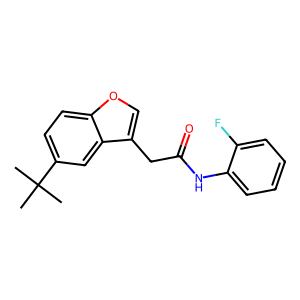

In [105]:
from rdkit.Chem import Draw

def validate_preprocess(unique_vocab, vocab_index = 259, choose_index = None, option = 'default'):

  '''
  This function draws the molecular structure of any molecule containing
  the desired unique_vocab instance for visual validation of joining rings
  for the preprocessing of nodes in the junction tree algorithm earlier

  Paramters:
    unique_vocab:
    vocab_index:

  '''
  if option == 'default':
      flipped_vocab = {value: key for key, value in unique_vocab.items()}

      if not choose_index:
        found_indexes = []
        for index in token_dictionary:
          try:
            index_found = token_dictionary[index].index(vocab_index)
            found_indexes.append(index)
          except ValueError:
            pass
      else:
        found_indexes = [choose_index]

      # Convert the SMILES string to an RDKit molecule object
      molecules = [Chem.MolFromSmiles(zinc_data['smiles'][index]) for index in found_indexes]

      # [print(list(atom)) for atom in Chem.GetSymmSSSR(molecule)]
      # Draw the molecules
      print('Vocabulary Token: ', flipped_vocab[vocab_index])
      return Draw.MolToImage(molecules[0])

  elif option == 'smiles_list':

      return unique_vocab
    
img       = None 
OPTION    = 'choose_index'
if OPTION == 'choose_index':
    img  = validate_preprocess(unique_vocab, vocab_index = 2, choose_index = 0)

elif OPTION == 'dictionary':
    images = []
    for smile in valency_dict['CCCCCC=']:
        images.append(validate_preprocess(smile, option = 'smiles_list'))

    img = Draw.MolsToGridImage(images, molsPerRow=4, subImgSize=(200, 200))  # Adjust 'molsPerRow' and 'subImgSize' as needed
img

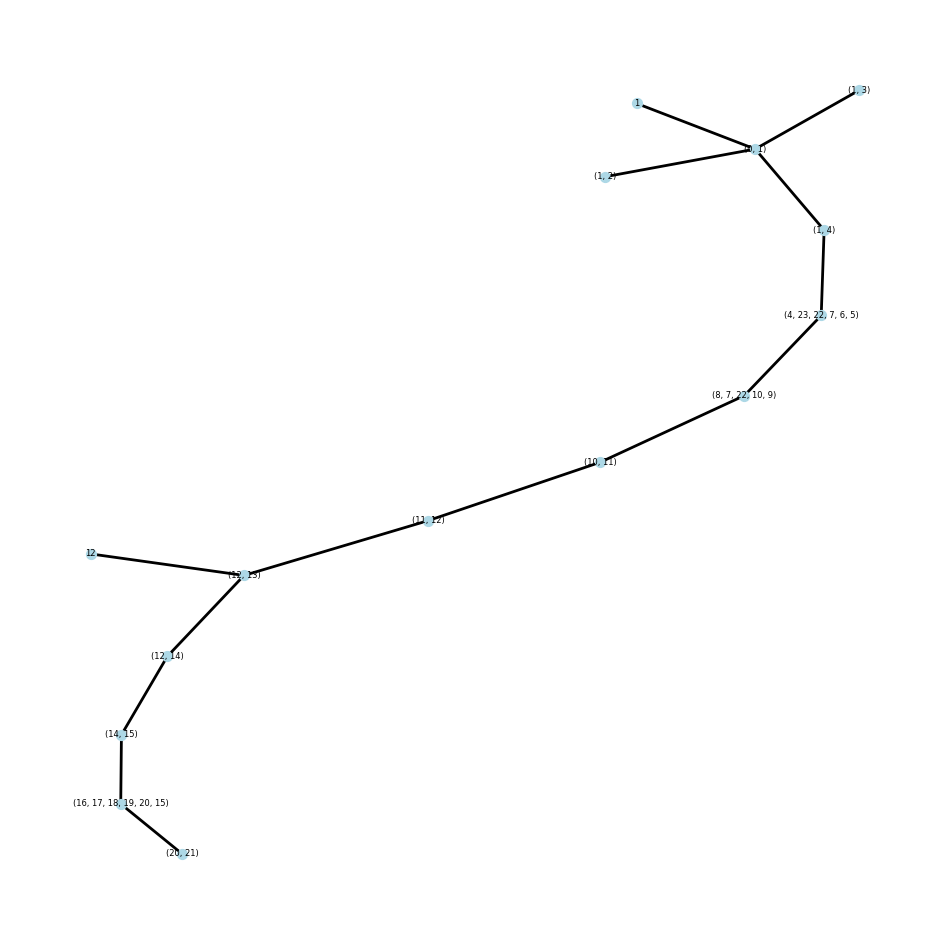

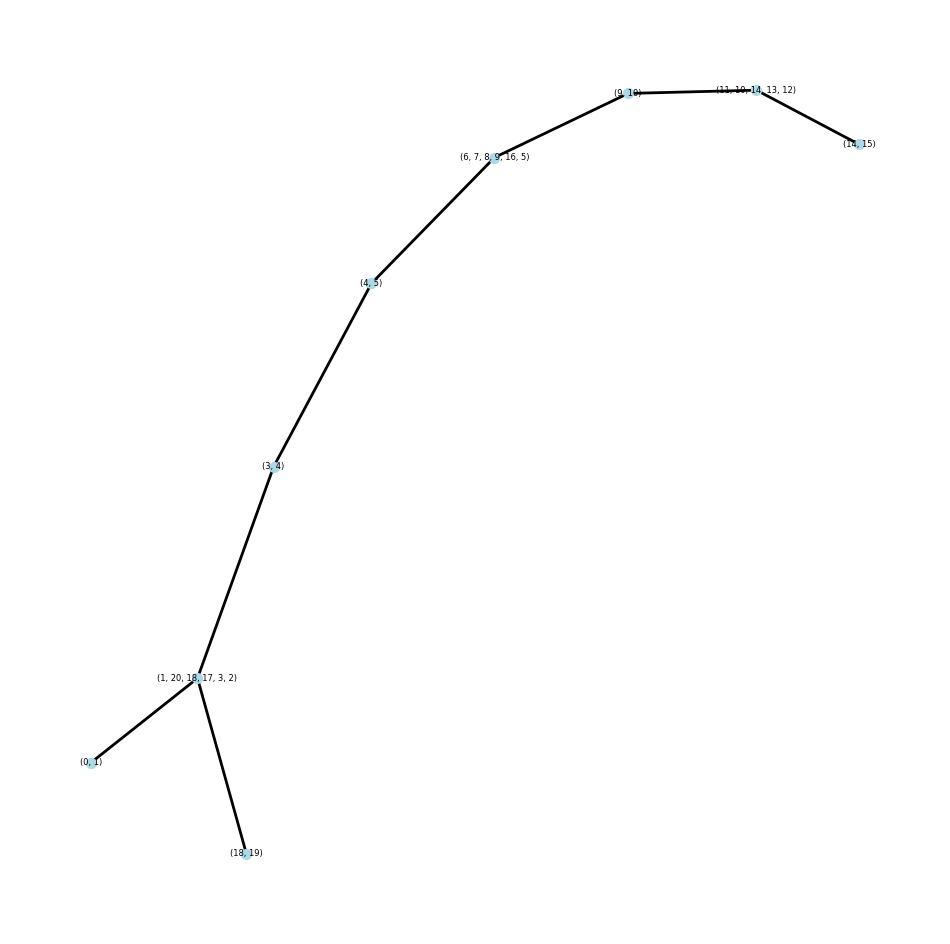

In [103]:
def plot_junction_tree(junction_tree, random_var = False, n_trees = 10, start_index = 0):
  # Draw the graph
  def plot(tree):
      plt.figure(figsize=(12, 12))  # Set the size of the plot
      pos = nx.spring_layout(tree)  # Positions for all nodes

      # Nodes
      nx.draw_networkx_nodes(tree, pos, node_size=50, node_color="lightblue")

      # Edges
      nx.draw_networkx_edges(tree, pos, width=2)

      # Labels
      nx.draw_networkx_labels(tree, pos, font_size=6, font_family="sans-serif")

      # Show the plot
      plt.axis("off")  # Turn off the axis
      plt.show()

  if not random_var:
     for tree in junction_tree[start_index:start_index + n_trees]:
      plot(tree)

  elif isinstance(junction_tree, list) and random_var:
    trees   = [random.randint(0, len(junction_tree)) for _ in range(n_trees)]
    for tree in junction_tree[:n_trees]:
      plot(tree)

plot_junction_tree(junction_tree, random_var = False, start_index = 0, n_trees = 2)


In [104]:
def substitute_vocabulary(adjacency_matricies, token_dictionary):
  ''' 
  Junction tree and adjacency matricies can be used with the token dictionary
  to map back the vocabulary into the adjacency_matricies
  
  Parameters:
      adjacency_matricies:
      token_dictionary:
      
  Returns:
      
      
  '''
  for index, atoms in tqdm(token_dictionary.items(), total = len(list(token_dictionary.values()))):
      list_index = 0
    
      matrix     = adjacency_matricies[index]
      for i in range(len(matrix)):
        for j in range(len(matrix)):
#             print(adjacency_matricies[index][i][j])
            if matrix[i][j] != 0:
#                 print(atoms, list_index, matrix.shape)
                atom_conversion                  = atoms[j]
                adjacency_matricies[index][i][j] = atom_conversion
                list_index += 1
        

  return np.array(adjacency_matricies)


adjacency_substituted = substitute_vocabulary(padded_matricies, token_dictionary)


100%|██████████| 249455/249455 [01:06<00:00, 3757.34it/s]
